In [149]:
# Install xgboost in notebook instance.
!pip install xgboost==1.2
!pip install imbalanced-learn==0.9.1

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [150]:
# Import required dependencies
import boto3
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from datetime import datetime

from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb_lib
from sklearn.linear_model import LogisticRegression

import sklearn

from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier
 
from collections import Counter
import shap

In [151]:
# Readind data
bucket_name = 'finance-factoring-ml-dev'

df = pd.read_csv('s3://{}/data/all.csv'.format(bucket_name))
df.head()

,Fecha,RFCCliente,RFCPagador,Moneda,FechaVencimiento,Monto,DepositoInicial,Intereses,FechaPago
0,1918.0,0,0,1,1953.0,38879.48,33047.56,2351.94,1939.0
1,1634.0,1,1,0,1654.0,6658.40,5659.64,109.45,1638.0
2,1583.0,2,2,1,1551.0,791.12,791.12,29.26,1551.0
3,2282.0,3,3,0,2225.0,33048.00,28090.80,814.88,2226.0
4,2110.0,4,4,0,2170.0,424634.82,360939.60,10615.87,2166.0


In [152]:
# Remove RFC Columns
df.drop("RFCPagador", axis=1, inplace=True)
df.drop("Moneda", axis=1, inplace=True)
df.drop("DepositoInicial", axis=1, inplace=True)
df.drop("Intereses", axis=1, inplace=True)
df.head()

,Fecha,RFCCliente,FechaVencimiento,Monto,FechaPago
0,1918.0,0,1953.0,38879.48,1939.0
1,1634.0,1,1654.0,6658.40,1638.0
2,1583.0,2,1551.0,791.12,1551.0
3,2282.0,3,2225.0,33048.00,2226.0
4,2110.0,4,2170.0,424634.82,2166.0


In [153]:
# Build feature Number of total paid invoices
def calc_delta(row):
    df_filtered = df[(df.RFCCliente == row.RFCCliente) & (df.Fecha < row.Fecha)]
    
    return len(df_filtered.index)

df['NumberTotalPaidInvoices'] = df.apply(calc_delta, axis=1)
df.head()

,Fecha,RFCCliente,FechaVencimiento,Monto,FechaPago,NumberTotalPaidInvoices
0,1918.0,0,1953.0,38879.48,1939.0,297
1,1634.0,1,1654.0,6658.40,1638.0,18
2,1583.0,2,1551.0,791.12,1551.0,7
3,2282.0,3,2225.0,33048.00,2226.0,774
4,2110.0,4,2170.0,424634.82,2166.0,9


In [154]:
# Build feature Number of invoices that were paid late
def calc_delta(row):
    df_filtered = df[(df.RFCCliente == row.RFCCliente) & (df.Fecha < row.Fecha)  & (df.FechaPago > df.FechaVencimiento)]
    
    return len(df_filtered.index)

df['NumberInvoicesPaidLate'] = df.apply(calc_delta, axis=1)
df.head()

,Fecha,RFCCliente,FechaVencimiento,Monto,FechaPago,NumberTotalPaidInvoices,NumberInvoicesPaidLate
0,1918.0,0,1953.0,38879.48,1939.0,297,67
1,1634.0,1,1654.0,6658.40,1638.0,18,4
2,1583.0,2,1551.0,791.12,1551.0,7,0
3,2282.0,3,2225.0,33048.00,2226.0,774,228
4,2110.0,4,2170.0,424634.82,2166.0,9,0


In [155]:
# Build feature Ratio of paid invoices that were late
def calc_delta(row):
    if row.NumberTotalPaidInvoices == 0:
        return 0
    else:
        return row.NumberInvoicesPaidLate / row.NumberTotalPaidInvoices

df['RatioInvoicesPaidLate'] = df.apply(calc_delta, axis=1)
df.head()

,Fecha,RFCCliente,FechaVencimiento,Monto,FechaPago,NumberTotalPaidInvoices,NumberInvoicesPaidLate,RatioInvoicesPaidLate
0,1918.0,0,1953.0,38879.48,1939.0,297,67,0.225589
1,1634.0,1,1654.0,6658.40,1638.0,18,4,0.222222
2,1583.0,2,1551.0,791.12,1551.0,7,0,0.000000
3,2282.0,3,2225.0,33048.00,2226.0,774,228,0.294574
4,2110.0,4,2170.0,424634.82,2166.0,9,0,0.000000


In [156]:
# Build feature Sum of the base amount of total paid invoices
def calc_delta(row):
    df_filtered = df[(df.RFCCliente == row.RFCCliente) & (df.Fecha < row.Fecha)]
    
    return df_filtered.Monto.sum()

df['SumAmountTotalPaidInvoices'] = df.apply(calc_delta, axis=1)
df.head()

,Fecha,RFCCliente,FechaVencimiento,Monto,FechaPago,NumberTotalPaidInvoices,NumberInvoicesPaidLate,RatioInvoicesPaidLate,SumAmountTotalPaidInvoices
0,1918.0,0,1953.0,38879.48,1939.0,297,67,0.225589,6888834.31
1,1634.0,1,1654.0,6658.40,1638.0,18,4,0.222222,537358.40
2,1583.0,2,1551.0,791.12,1551.0,7,0,0.000000,8373.86
3,2282.0,3,2225.0,33048.00,2226.0,774,228,0.294574,26762583.68
4,2110.0,4,2170.0,424634.82,2166.0,9,0,0.000000,2340876.72


In [157]:
# Build feature Sum of the base amount of invoices that were paid late
def calc_delta(row):
    df_filtered = df[(df.RFCCliente == row.RFCCliente) & (df.Fecha < row.Fecha) & (df.FechaPago > df.FechaVencimiento)]
    
    return df_filtered.Monto.sum()

df['SumAmountInvoicesPaidLate'] = df.apply(calc_delta, axis=1)
df.head()

,Fecha,RFCCliente,FechaVencimiento,Monto,FechaPago,NumberTotalPaidInvoices,NumberInvoicesPaidLate,RatioInvoicesPaidLate,SumAmountTotalPaidInvoices,SumAmountInvoicesPaidLate
0,1918.0,0,1953.0,38879.48,1939.0,297,67,0.225589,6888834.31,1687615.30
1,1634.0,1,1654.0,6658.40,1638.0,18,4,0.222222,537358.40,58817.80
2,1583.0,2,1551.0,791.12,1551.0,7,0,0.000000,8373.86,0.00
3,2282.0,3,2225.0,33048.00,2226.0,774,228,0.294574,26762583.68,12413230.36
4,2110.0,4,2170.0,424634.82,2166.0,9,0,0.000000,2340876.72,0.00


In [158]:
# Build feature Ratio of sum of paid base amount that were late
def calc_delta(row):
    if row.SumAmountTotalPaidInvoices == 0:
        return 0
    else:
        return row.SumAmountInvoicesPaidLate / row.SumAmountTotalPaidInvoices

df['RatioSumAmountInvoicesPaidLate'] = df.apply(calc_delta, axis=1)
df.head()

,Fecha,RFCCliente,FechaVencimiento,Monto,FechaPago,NumberTotalPaidInvoices,NumberInvoicesPaidLate,RatioInvoicesPaidLate,SumAmountTotalPaidInvoices,SumAmountInvoicesPaidLate,RatioSumAmountInvoicesPaidLate
0,1918.0,0,1953.0,38879.48,1939.0,297,67,0.225589,6888834.31,1687615.30,0.244978
1,1634.0,1,1654.0,6658.40,1638.0,18,4,0.222222,537358.40,58817.80,0.109457
2,1583.0,2,1551.0,791.12,1551.0,7,0,0.000000,8373.86,0.00,0.000000
3,2282.0,3,2225.0,33048.00,2226.0,774,228,0.294574,26762583.68,12413230.36,0.463828
4,2110.0,4,2170.0,424634.82,2166.0,9,0,0.000000,2340876.72,0.00,0.000000


In [159]:
# Build feature Average days late of paid invoices being late.
def calc_delta(row):
    df_filtered = df[(df.RFCCliente == row.RFCCliente) & (df.Fecha < row.Fecha) & (df.FechaPago > df.FechaVencimiento)]
  
    df_filtered['DaysLate'] = df_filtered['FechaPago'] - df_filtered['FechaVencimiento']
    
    if len(df_filtered.index) == 0:
        return 0
    else:
        return df_filtered.DaysLate.mean()

df['AvgDaysLateInvoicesPaidLate'] = df.apply(calc_delta, axis=1)
df.head()

,Fecha,RFCCliente,FechaVencimiento,Monto,FechaPago,NumberTotalPaidInvoices,NumberInvoicesPaidLate,RatioInvoicesPaidLate,SumAmountTotalPaidInvoices,SumAmountInvoicesPaidLate,RatioSumAmountInvoicesPaidLate,AvgDaysLateInvoicesPaidLate
0,1918.0,0,1953.0,38879.48,1939.0,297,67,0.225589,6888834.31,1687615.30,0.244978,15.701493
1,1634.0,1,1654.0,6658.40,1638.0,18,4,0.222222,537358.40,58817.80,0.109457,7.000000
2,1583.0,2,1551.0,791.12,1551.0,7,0,0.000000,8373.86,0.00,0.000000,0.000000
3,2282.0,3,2225.0,33048.00,2226.0,774,228,0.294574,26762583.68,12413230.36,0.463828,5.701754
4,2110.0,4,2170.0,424634.82,2166.0,9,0,0.000000,2340876.72,0.00,0.000000,0.000000


In [160]:
# Build feature Number of total outstanding invoices
def calc_delta(row):
    df_filtered = df[(df.RFCCliente == row.RFCCliente) & (df.Fecha < row.Fecha) & (df.FechaPago > row.Fecha)]
  
    return len(df_filtered.index)

df['NumberTotalOutstandingInvoices'] = df.apply(calc_delta, axis=1)
df.head()

,Fecha,RFCCliente,FechaVencimiento,Monto,FechaPago,NumberTotalPaidInvoices,NumberInvoicesPaidLate,RatioInvoicesPaidLate,SumAmountTotalPaidInvoices,SumAmountInvoicesPaidLate,RatioSumAmountInvoicesPaidLate,AvgDaysLateInvoicesPaidLate,NumberTotalOutstandingInvoices
0,1918.0,0,1953.0,38879.48,1939.0,297,67,0.225589,6888834.31,1687615.30,0.244978,15.701493,20
1,1634.0,1,1654.0,6658.40,1638.0,18,4,0.222222,537358.40,58817.80,0.109457,7.000000,18
2,1583.0,2,1551.0,791.12,1551.0,7,0,0.000000,8373.86,0.00,0.000000,0.000000,4
3,2282.0,3,2225.0,33048.00,2226.0,774,228,0.294574,26762583.68,12413230.36,0.463828,5.701754,36
4,2110.0,4,2170.0,424634.82,2166.0,9,0,0.000000,2340876.72,0.00,0.000000,0.000000,0


In [161]:
# Build feature Number of outstanding invoices that were already late
def calc_delta(row):
    df_filtered = df[(df.RFCCliente == row.RFCCliente) & (df.Fecha < row.Fecha) & (df.FechaPago > df.FechaVencimiento) & (df.FechaPago > row.Fecha)]
  
    return len(df_filtered.index)

df['NumberOutstandingLateInvoices'] = df.apply(calc_delta, axis=1)
df.head()

,Fecha,RFCCliente,FechaVencimiento,Monto,FechaPago,NumberTotalPaidInvoices,NumberInvoicesPaidLate,RatioInvoicesPaidLate,SumAmountTotalPaidInvoices,SumAmountInvoicesPaidLate,RatioSumAmountInvoicesPaidLate,AvgDaysLateInvoicesPaidLate,NumberTotalOutstandingInvoices,NumberOutstandingLateInvoices
0,1918.0,0,1953.0,38879.48,1939.0,297,67,0.225589,6888834.31,1687615.30,0.244978,15.701493,20,10
1,1634.0,1,1654.0,6658.40,1638.0,18,4,0.222222,537358.40,58817.80,0.109457,7.000000,18,4
2,1583.0,2,1551.0,791.12,1551.0,7,0,0.000000,8373.86,0.00,0.000000,0.000000,4,0
3,2282.0,3,2225.0,33048.00,2226.0,774,228,0.294574,26762583.68,12413230.36,0.463828,5.701754,36,6
4,2110.0,4,2170.0,424634.82,2166.0,9,0,0.000000,2340876.72,0.00,0.000000,0.000000,0,0


In [162]:
# Build feature Ratio of outstanding invoices that were late
def calc_delta(row):
    if row.NumberTotalOutstandingInvoices == 0:
        return 0
    else:
        return row.NumberOutstandingLateInvoices / row.NumberTotalOutstandingInvoices

df['RatioOutstandingLateInvoices'] = df.apply(calc_delta, axis=1)
df.head()

,Fecha,RFCCliente,FechaVencimiento,Monto,FechaPago,NumberTotalPaidInvoices,NumberInvoicesPaidLate,RatioInvoicesPaidLate,SumAmountTotalPaidInvoices,SumAmountInvoicesPaidLate,RatioSumAmountInvoicesPaidLate,AvgDaysLateInvoicesPaidLate,NumberTotalOutstandingInvoices,NumberOutstandingLateInvoices,RatioOutstandingLateInvoices
0,1918.0,0,1953.0,38879.48,1939.0,297,67,0.225589,6888834.31,1687615.30,0.244978,15.701493,20,10,0.500000
1,1634.0,1,1654.0,6658.40,1638.0,18,4,0.222222,537358.40,58817.80,0.109457,7.000000,18,4,0.222222
2,1583.0,2,1551.0,791.12,1551.0,7,0,0.000000,8373.86,0.00,0.000000,0.000000,4,0,0.000000
3,2282.0,3,2225.0,33048.00,2226.0,774,228,0.294574,26762583.68,12413230.36,0.463828,5.701754,36,6,0.166667
4,2110.0,4,2170.0,424634.82,2166.0,9,0,0.000000,2340876.72,0.00,0.000000,0.000000,0,0,0.000000


In [163]:
# Build feature Sum of the base amount of total outstanding invoices
def calc_delta(row):
    df_filtered = df[(df.RFCCliente == row.RFCCliente) & (df.Fecha < row.Fecha) & (df.FechaPago > row.Fecha)]
  
    return df_filtered.Monto.sum()

df['SumAmountTotalOutstandingInvoices'] = df.apply(calc_delta, axis=1)
df.head()

,Fecha,RFCCliente,FechaVencimiento,Monto,FechaPago,NumberTotalPaidInvoices,NumberInvoicesPaidLate,RatioInvoicesPaidLate,SumAmountTotalPaidInvoices,SumAmountInvoicesPaidLate,RatioSumAmountInvoicesPaidLate,AvgDaysLateInvoicesPaidLate,NumberTotalOutstandingInvoices,NumberOutstandingLateInvoices,RatioOutstandingLateInvoices,SumAmountTotalOutstandingInvoices
0,1918.0,0,1953.0,38879.48,1939.0,297,67,0.225589,6888834.31,1687615.30,0.244978,15.701493,20,10,0.500000,510099.33
1,1634.0,1,1654.0,6658.40,1638.0,18,4,0.222222,537358.40,58817.80,0.109457,7.000000,18,4,0.222222,537358.40
2,1583.0,2,1551.0,791.12,1551.0,7,0,0.000000,8373.86,0.00,0.000000,0.000000,4,0,0.000000,4110.39
3,2282.0,3,2225.0,33048.00,2226.0,774,228,0.294574,26762583.68,12413230.36,0.463828,5.701754,36,6,0.166667,1097807.95
4,2110.0,4,2170.0,424634.82,2166.0,9,0,0.000000,2340876.72,0.00,0.000000,0.000000,0,0,0.000000,0.00


In [164]:
# Build feature Sum of the base amount of outstanding invoices that were late
def calc_delta(row):
    df_filtered = df[(df.RFCCliente == row.RFCCliente) & (df.Fecha < row.Fecha) & (df.FechaPago > row.Fecha) & (df.FechaPago > df.FechaVencimiento)]
  
    return df_filtered.Monto.sum()

df['SumAmountOutstandingLateInvoices'] = df.apply(calc_delta, axis=1)
df.head()

,Fecha,RFCCliente,FechaVencimiento,Monto,FechaPago,NumberTotalPaidInvoices,NumberInvoicesPaidLate,RatioInvoicesPaidLate,SumAmountTotalPaidInvoices,SumAmountInvoicesPaidLate,RatioSumAmountInvoicesPaidLate,AvgDaysLateInvoicesPaidLate,NumberTotalOutstandingInvoices,NumberOutstandingLateInvoices,RatioOutstandingLateInvoices,SumAmountTotalOutstandingInvoices,SumAmountOutstandingLateInvoices
0,1918.0,0,1953.0,38879.48,1939.0,297,67,0.225589,6888834.31,1687615.30,0.244978,15.701493,20,10,0.500000,510099.33,249381.40
1,1634.0,1,1654.0,6658.40,1638.0,18,4,0.222222,537358.40,58817.80,0.109457,7.000000,18,4,0.222222,537358.40,58817.80
2,1583.0,2,1551.0,791.12,1551.0,7,0,0.000000,8373.86,0.00,0.000000,0.000000,4,0,0.000000,4110.39,0.00
3,2282.0,3,2225.0,33048.00,2226.0,774,228,0.294574,26762583.68,12413230.36,0.463828,5.701754,36,6,0.166667,1097807.95,549081.45
4,2110.0,4,2170.0,424634.82,2166.0,9,0,0.000000,2340876.72,0.00,0.000000,0.000000,0,0,0.000000,0.00,0.00


In [165]:
# Build feature Ratio of sum of outstanding base amount that were late
def calc_delta(row):
    if row.SumAmountTotalOutstandingInvoices == 0:
        return 0
    else:
        return row.SumAmountOutstandingLateInvoices / row.SumAmountTotalOutstandingInvoices

df['RatioSumAmountOutstandingLateInvoice'] = df.apply(calc_delta, axis=1)
df.head()

,Fecha,RFCCliente,FechaVencimiento,Monto,FechaPago,NumberTotalPaidInvoices,NumberInvoicesPaidLate,RatioInvoicesPaidLate,SumAmountTotalPaidInvoices,SumAmountInvoicesPaidLate,RatioSumAmountInvoicesPaidLate,AvgDaysLateInvoicesPaidLate,NumberTotalOutstandingInvoices,NumberOutstandingLateInvoices,RatioOutstandingLateInvoices,SumAmountTotalOutstandingInvoices,SumAmountOutstandingLateInvoices,RatioSumAmountOutstandingLateInvoice
0,1918.0,0,1953.0,38879.48,1939.0,297,67,0.225589,6888834.31,1687615.30,0.244978,15.701493,20,10,0.500000,510099.33,249381.40,0.488888
1,1634.0,1,1654.0,6658.40,1638.0,18,4,0.222222,537358.40,58817.80,0.109457,7.000000,18,4,0.222222,537358.40,58817.80,0.109457
2,1583.0,2,1551.0,791.12,1551.0,7,0,0.000000,8373.86,0.00,0.000000,0.000000,4,0,0.000000,4110.39,0.00,0.000000
3,2282.0,3,2225.0,33048.00,2226.0,774,228,0.294574,26762583.68,12413230.36,0.463828,5.701754,36,6,0.166667,1097807.95,549081.45,0.500162
4,2110.0,4,2170.0,424634.82,2166.0,9,0,0.000000,2340876.72,0.00,0.000000,0.000000,0,0,0.000000,0.00,0.00,0.000000


In [172]:
# Build feature Average days late of outstanding invoices being late.
def calc_delta(row):
    df_filtered = df[(df.RFCCliente == row.RFCCliente) & (df.Fecha < row.Fecha) & (df.FechaPago > df.FechaVencimiento) & (df.FechaPago > row.Fecha)]
  
    df_filtered['DaysLate'] = df_filtered['FechaPago'] - df_filtered['FechaVencimiento']
    
    if len(df_filtered.index) == 0:
        return 0
    else:
        return df_filtered.DaysLate.mean()

df['AvgDaysLateInvoicesPaidLate'] = df.apply(calc_delta, axis=1)
df.head()

AttributeError: 'DataFrame' object has no attribute 'RFCCliente'

# 5. Prepare dataframes for modeling approaches

Build temporary **DaysLate** column

In [167]:
def calc_delta(row):
    days = (row['FechaPago'] - row['FechaVencimiento'])
    return days if days > 0 else 0

df['DaysLate'] = df.apply(calc_delta, axis=1)

# Remove "FechaPago" and RFCCliente features
df.drop("FechaPago", axis=1, inplace=True)
df.drop("RFCCliente", axis=1, inplace=True)

df.head()

,Fecha,FechaVencimiento,Monto,NumberTotalPaidInvoices,NumberInvoicesPaidLate,RatioInvoicesPaidLate,SumAmountTotalPaidInvoices,SumAmountInvoicesPaidLate,RatioSumAmountInvoicesPaidLate,AvgDaysLateInvoicesPaidLate,NumberTotalOutstandingInvoices,NumberOutstandingLateInvoices,RatioOutstandingLateInvoices,SumAmountTotalOutstandingInvoices,SumAmountOutstandingLateInvoices,RatioSumAmountOutstandingLateInvoice,DaysLate
0,1918.0,1953.0,38879.48,297,67,0.225589,6888834.31,1687615.30,0.244978,19.400000,20,10,0.500000,510099.33,249381.40,0.488888,0.0
1,1634.0,1654.0,6658.40,18,4,0.222222,537358.40,58817.80,0.109457,7.000000,18,4,0.222222,537358.40,58817.80,0.109457,0.0
2,1583.0,1551.0,791.12,7,0,0.000000,8373.86,0.00,0.000000,0.000000,4,0,0.000000,4110.39,0.00,0.000000,0.0
3,2282.0,2225.0,33048.00,774,228,0.294574,26762583.68,12413230.36,0.463828,4.333333,36,6,0.166667,1097807.95,549081.45,0.500162,1.0
4,2110.0,2170.0,424634.82,9,0,0.000000,2340876.72,0.00,0.000000,0.000000,0,0,0.000000,0.00,0.00,0.000000,0.0


TODO
Build target column **PaidTime**
> * 1: On time
> * 2: Late payment 1-3 days
> * 3: Late payment 4-7 days
> * 4: Late payment 8-14 days
> * 5: Late payment >= 15 days

In [168]:
def build_paidTime(row):
    if row.DaysLate == 0:
        return 1
    if row.DaysLate <= 3:
        return 2
    if row.DaysLate <= 7:
        return 3
    if row.DaysLate <= 14:
        return 4
    else:
        return 5

df['PaidTime'] = df.apply(build_paidTime, axis=1)

df.head()

,Fecha,FechaVencimiento,Monto,NumberTotalPaidInvoices,NumberInvoicesPaidLate,RatioInvoicesPaidLate,SumAmountTotalPaidInvoices,SumAmountInvoicesPaidLate,RatioSumAmountInvoicesPaidLate,AvgDaysLateInvoicesPaidLate,NumberTotalOutstandingInvoices,NumberOutstandingLateInvoices,RatioOutstandingLateInvoices,SumAmountTotalOutstandingInvoices,SumAmountOutstandingLateInvoices,RatioSumAmountOutstandingLateInvoice,DaysLate,PaidTime
0,1918.0,1953.0,38879.48,297,67,0.225589,6888834.31,1687615.30,0.244978,19.400000,20,10,0.500000,510099.33,249381.40,0.488888,0.0,1
1,1634.0,1654.0,6658.40,18,4,0.222222,537358.40,58817.80,0.109457,7.000000,18,4,0.222222,537358.40,58817.80,0.109457,0.0,1
2,1583.0,1551.0,791.12,7,0,0.000000,8373.86,0.00,0.000000,0.000000,4,0,0.000000,4110.39,0.00,0.000000,0.0,1
3,2282.0,2225.0,33048.00,774,228,0.294574,26762583.68,12413230.36,0.463828,4.333333,36,6,0.166667,1097807.95,549081.45,0.500162,1.0,2
4,2110.0,2170.0,424634.82,9,0,0.000000,2340876.72,0.00,0.000000,0.000000,0,0,0.000000,0.00,0.00,0.000000,0.0,1


In [173]:
# Remove "DaysLate" because it's not gonna be needed anymore
df.drop("DaysLate", axis=1, inplace=True)
df.head()

KeyError: "['DaysLate'] not found in axis"

Separate target for predictions

In [174]:
X = df.drop(['PaidTime'], axis=1)
y = df.PaidTime

In [175]:
# Break off validation set from training data set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)
print('Trainging dataset shape: ', X_train.shape)
print('Test dataset shape: ', X_test.shape)

Trainging dataset shape:  (14966, 16)
Test dataset shape:  (3742, 16)


In [176]:
# Helper function to plot confusion matrix
def render_confusion_matrix(y_test_input, predicted, clasess):
    ac_s = accuracy_score(y_test_input, predicted)
    print('The Accuracy is: ', int(ac_s * 100), " %")

    cm = confusion_matrix(y_test_input, predicted, labels=clasess)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clasess)
    disp.plot()
    return ac_s

In [177]:
# Helper function to plot models accuracies
def plot_models_accuracy(models_name, accuracies):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(models_name,accuracies)
    _ = plt.xticks(rotation=90,fontsize=14)
    plt.title('Compare accuracy (test)')
    plt.ylim(0.30, 1.0)
    plt.show()   

## 5.1 Decision Tree Classifier

The Accuracy is:  84  %


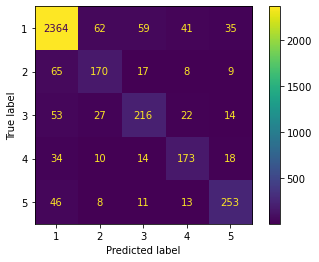

In [178]:
tree = DecisionTreeClassifier()
tree = tree.fit(X_train, y_train)

predicted_tree = tree.predict(X_test)

ac_simple = render_confusion_matrix(y_test, predicted_tree, tree.classes_)
# ac_tree = accuracy_score(y_test, predicted_tree)
# print('The Accuracy for DecisionTreeClassifier is: ', int(ac_tree * 100), " %")

# cm = confusion_matrix(y_test, predicted_tree, labels=tree.classes_)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tree.classes_)
# disp.plot()

## Feature Importance

Feature: 0, Score: 0.06097
Feature: 1, Score: 0.25069
Feature: 2, Score: 0.14458
Feature: 3, Score: 0.04076
Feature: 4, Score: 0.01420
Feature: 5, Score: 0.04790
Feature: 6, Score: 0.03564
Feature: 7, Score: 0.01632
Feature: 8, Score: 0.04891
Feature: 9, Score: 0.02251
Feature: 10, Score: 0.06683
Feature: 11, Score: 0.05150
Feature: 12, Score: 0.12158
Feature: 13, Score: 0.03840
Feature: 14, Score: 0.01709
Feature: 15, Score: 0.02213


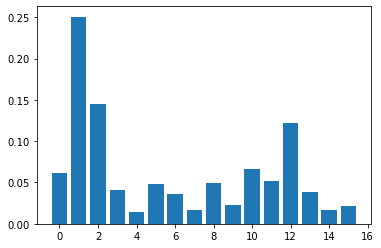

Index(['Fecha', 'FechaVencimiento', 'Monto', 'NumberTotalPaidInvoices',
       'NumberInvoicesPaidLate', 'RatioInvoicesPaidLate',
       'SumAmountTotalPaidInvoices', 'SumAmountInvoicesPaidLate',
       'RatioSumAmountInvoicesPaidLate', 'AvgDaysLateInvoicesPaidLate',
       'NumberTotalOutstandingInvoices', 'NumberOutstandingLateInvoices',
       'RatioOutstandingLateInvoices', 'SumAmountTotalOutstandingInvoices',
       'SumAmountOutstandingLateInvoices',
       'RatioSumAmountOutstandingLateInvoice', 'PaidTime'],
      dtype='object')


In [179]:
# get importance
importance = tree.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

print(df.columns)

## Shap values

In [230]:
row_to_show = 5
data_for_prediction = X_train.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
explainer = shap.TreeExplainer(tree)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

In [181]:
# Fits the explainer
explainer = shap.Explainer(tree.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)

Permutation explainer: 3743it [02:15, 26.25it/s]                          


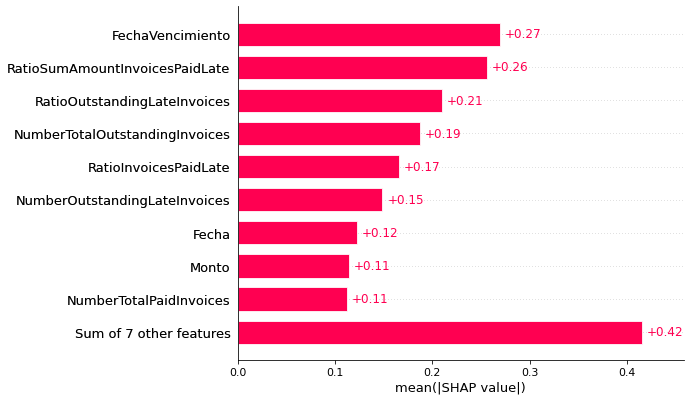

In [182]:
shap.plots.bar(shap_values)

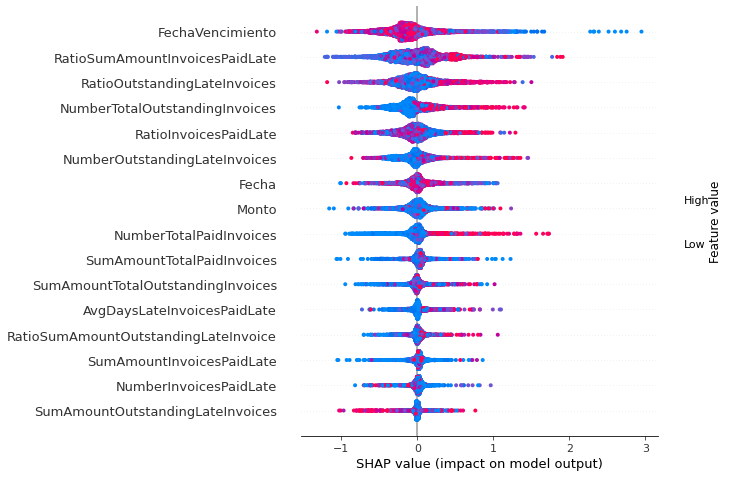

In [183]:
shap.summary_plot(shap_values)

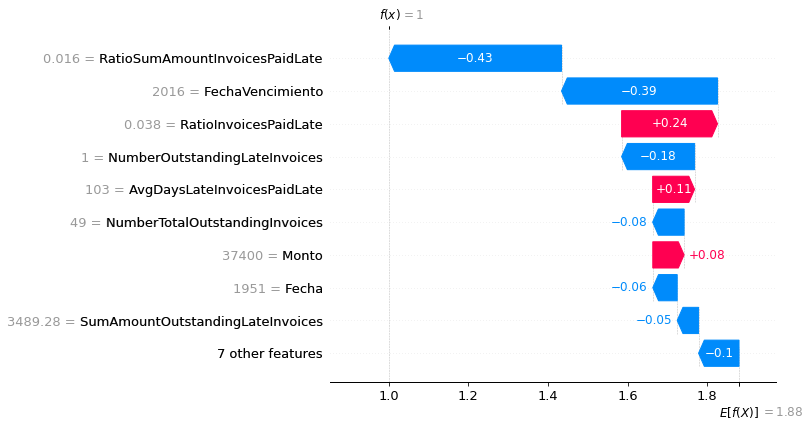

In [185]:
shap.plots.waterfall(shap_values[0])

In [186]:
shap.plots.force(shap_values[100])

Distribution before resampling Counter({1: 10371, 3: 1362, 5: 1322, 2: 1031, 4: 880})
Distribution after resampling Counter({1: 880, 2: 880, 3: 880, 4: 880, 5: 880})
The Accuracy is:  30  %


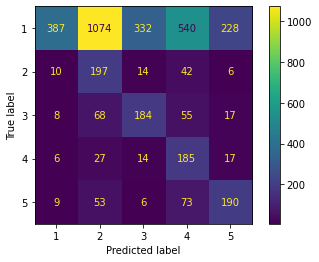

In [187]:
us = NearMiss()

X_train_res, y_train_res = us.fit_resample(X_train, y_train)
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

tree = tree.fit(X_train_res, y_train_res)

predicted_tree = tree.predict(X_test)

ac_under_sampling = render_confusion_matrix(y_test, predicted_tree, tree.classes_)

Distribution before resampling Counter({1: 10371, 3: 1362, 5: 1322, 2: 1031, 4: 880})
Distribution labels after resampling Counter({1: 10371, 4: 10371, 5: 10371, 2: 10371, 3: 10371})
The Accuracy is:  85  %


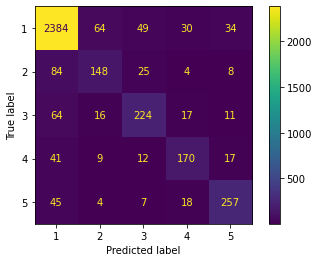

In [188]:
os = RandomOverSampler()
X_train_res, y_train_res = os.fit_resample(X_train, y_train)
 
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution labels after resampling {}".format(Counter(y_train_res)))
 
tree = tree.fit(X_train_res, y_train_res)

predicted_tree = tree.predict(X_test)

ac_over_sampling = render_confusion_matrix(y_test, predicted_tree, tree.classes_)

Distribution before resampling Counter({1: 10371, 3: 1362, 5: 1322, 2: 1031, 4: 880})
Distribution after resampling Counter({5: 10042, 1: 9883, 2: 9852, 4: 9829, 3: 9715})
The Accuracy is:  82  %


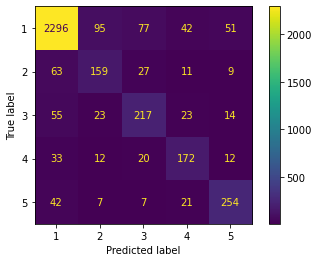

In [189]:
os_us = SMOTETomek()
X_train_res, y_train_res = os_us.fit_resample(X_train, y_train)
 
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

tree = tree.fit(X_train_res, y_train_res)

predicted_tree = tree.predict(X_test)

ac_mixed = render_confusion_matrix(y_test, predicted_tree, tree.classes_)

### 5.1.1 Decision Tree accuracies

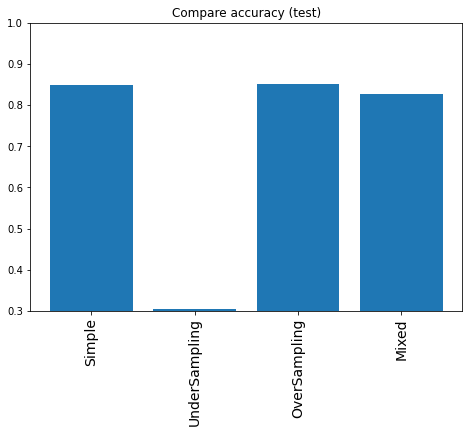

In [190]:
accuracies = [ac_simple, ac_under_sampling, ac_over_sampling, ac_mixed]
models_name = ['Simple', 'UnderSampling', 'OverSampling', 'Mixed']
plot_models_accuracy(models_name, accuracies)

## 5.2 XGBoost Classifier

The Accuracy is:  85  %


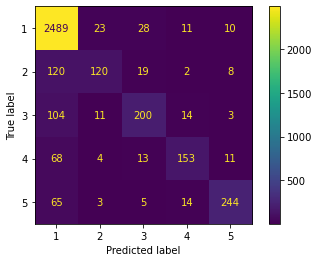

In [191]:
xgb = XGBClassifier(random_state=0,
                    n_estimators=1000,
                    max_depth=3,
                    learning_rate=0.1,
                    objective='binary:logistic',
                    verbosity=0,
                    use_label_encoder=False)

xgb = xgb.fit(X_train, y_train)

predicted_xgb = xgb.predict(X_test)

ac_simple = render_confusion_matrix(y_test, predicted_xgb, xgb.classes_)

# ac_xgb = accuracy_score(y_test, predicted_xgb)
# print('The Accuracy for XGBClassifier is: ', int(ac_xgb * 100), " %")

# cm = confusion_matrix(y_test, predicted_xgb, labels=xgb.classes_)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb.classes_)
# disp.plot()

Feature: 0, Score: 0.05153
Feature: 1, Score: 0.07124
Feature: 2, Score: 0.02399
Feature: 3, Score: 0.07009
Feature: 4, Score: 0.05877
Feature: 5, Score: 0.07110
Feature: 6, Score: 0.04492
Feature: 7, Score: 0.03792
Feature: 8, Score: 0.06152
Feature: 9, Score: 0.05826
Feature: 10, Score: 0.07758
Feature: 11, Score: 0.05330
Feature: 12, Score: 0.19196
Feature: 13, Score: 0.04093
Feature: 14, Score: 0.04160
Feature: 15, Score: 0.04528


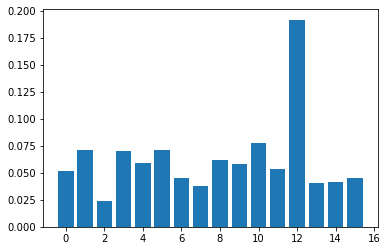

Index(['Fecha', 'FechaVencimiento', 'Monto', 'NumberTotalPaidInvoices',
       'NumberInvoicesPaidLate', 'RatioInvoicesPaidLate',
       'SumAmountTotalPaidInvoices', 'SumAmountInvoicesPaidLate',
       'RatioSumAmountInvoicesPaidLate', 'AvgDaysLateInvoicesPaidLate',
       'NumberTotalOutstandingInvoices', 'NumberOutstandingLateInvoices',
       'RatioOutstandingLateInvoices', 'SumAmountTotalOutstandingInvoices',
       'SumAmountOutstandingLateInvoices',
       'RatioSumAmountOutstandingLateInvoice', 'PaidTime'],
      dtype='object')


In [192]:
# get importance
importance = xgb.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

print(df.columns)

Distribution before resampling Counter({1: 10371, 3: 1362, 5: 1322, 2: 1031, 4: 880})
Distribution after resampling Counter({1: 880, 2: 880, 3: 880, 4: 880, 5: 880})
The Accuracy is:  30  %


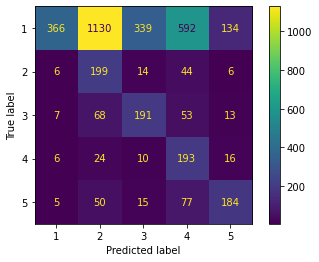

In [197]:
us = NearMiss()

X_train_res, y_train_res = us.fit_resample(X_train, y_train)
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

xgb = xgb.fit(X_train_res, y_train_res)

predicted = xgb.predict(X_test)

ac_under_sampling = render_confusion_matrix(y_test, predicted, xgb.classes_)

Distribution before resampling Counter({1: 10371, 3: 1362, 5: 1322, 2: 1031, 4: 880})
Distribution labels after resampling Counter({1: 10371, 4: 10371, 5: 10371, 2: 10371, 3: 10371})
The Accuracy is:  79  %


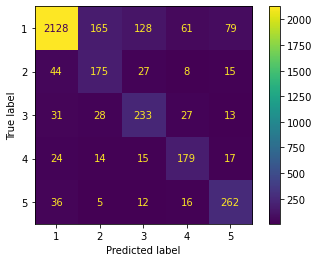

In [198]:
os = RandomOverSampler()
X_train_res, y_train_res = os.fit_resample(X_train, y_train)
 
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution labels after resampling {}".format(Counter(y_train_res)))

xgb = xgb.fit(X_train_res, y_train_res)

predicted = xgb.predict(X_test)

ac_over_sampling = render_confusion_matrix(y_test, predicted, xgb.classes_)

Distribution before resampling Counter({1: 10371, 3: 1362, 5: 1322, 2: 1031, 4: 880})
Distribution after resampling Counter({5: 10052, 1: 9884, 2: 9850, 4: 9838, 3: 9693})
The Accuracy is:  78  %


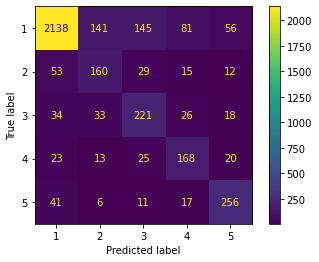

In [199]:
os_us = SMOTETomek()
X_train_res, y_train_res = os_us.fit_resample(X_train, y_train)
 
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

xgb = xgb.fit(X_train_res, y_train_res)

predicted = xgb.predict(X_test)

ac_mixed = render_confusion_matrix(y_test, predicted, xgb.classes_)

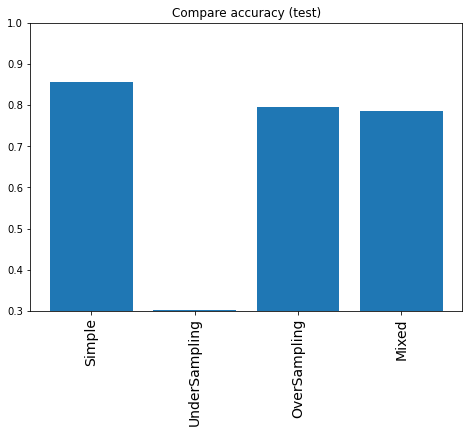

In [200]:
accuracies = [ac_simple, ac_under_sampling, ac_over_sampling, ac_mixed]
plot_models_accuracy(models_name, accuracies)